In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from data.prep import get_data_as_dataframe
from utils.data_utils import custom_train_test_split, calculate_mean_std

from models.vit import ViT

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.train_utils import EarlyStopping
from engine import train, eval

from plots import plot_metrics_curve, plot_conf_matrix, plot_precision_recall_curve, plot_roc_curve

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [2]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = True

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [3]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

# Dataset name
DATASET_NAME = 'SDNET2018'

df = get_data_as_dataframe(DATA_PATH, dataset_name=DATASET_NAME, balance=True)
df.head()

,image,label
0,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
1,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
2,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
3,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
4,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked


In [4]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4172, 2)
Validation size: (783, 2)
Test size: (261, 2)


In [5]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    2086
cracked        2086
Name: label, dtype: int64

Validation data balance:
 non-cracked    392
cracked        391
Name: label, dtype: int64

Test data balance:
 cracked        131
non-cracked    130
Name: label, dtype: int64



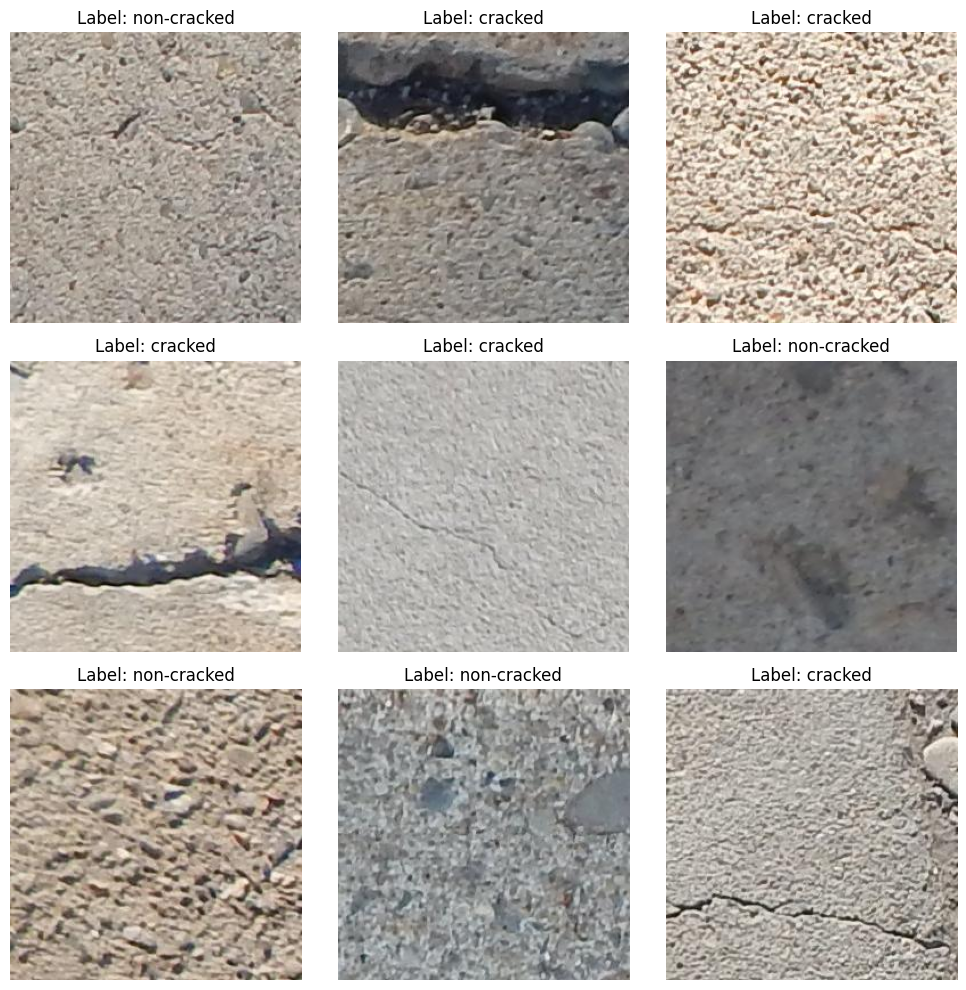

In [6]:
from plots import show_df

show_df(df=df, n_samples=9)

# Initialize Dataset and Dataloader for Training

In [7]:
class CrackDataset(Dataset):
    def __init__(self, df, dataset_name, transform=None):
        super().__init__()
        self.df_data = df.values
        self.dataset_name = dataset_name
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 64

if PRETRAINED:
    MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
else:
    MEAN, STD = calculate_mean_std(train_df.copy())

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD), 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: 64


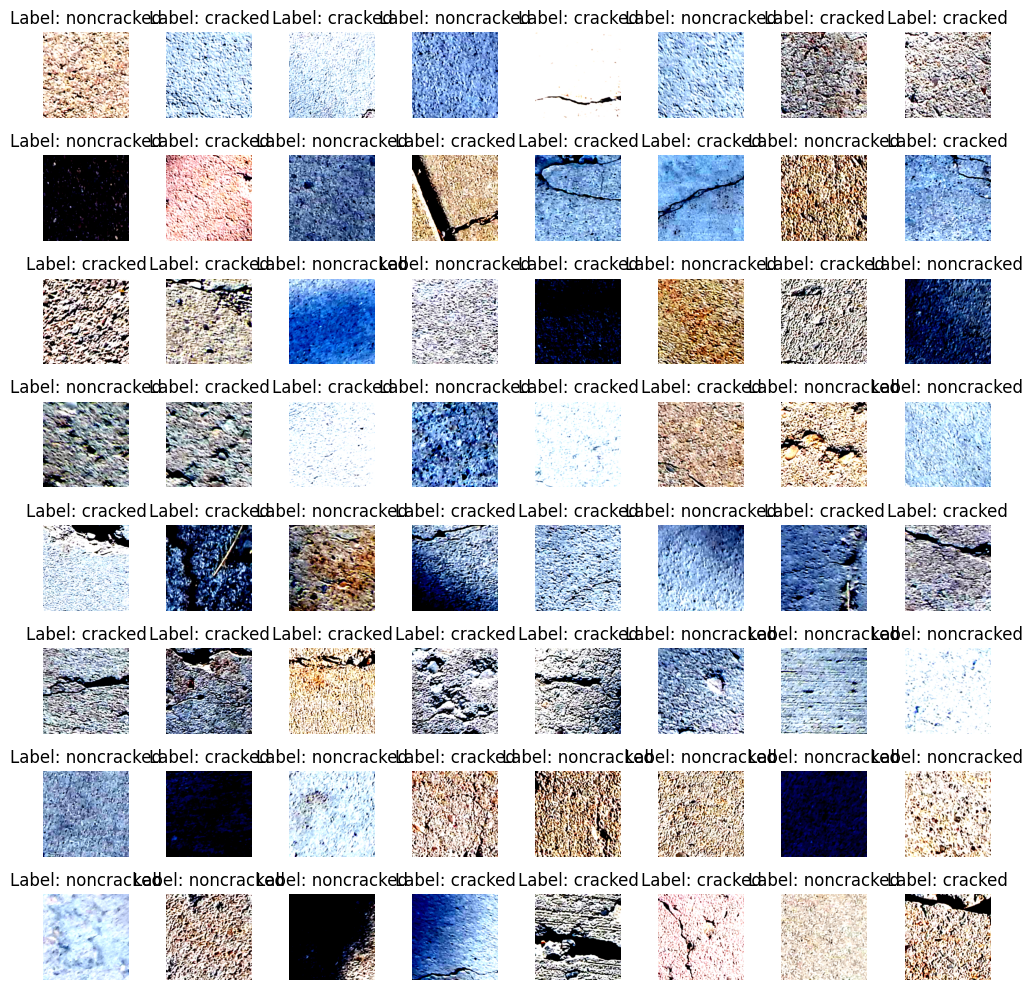

In [9]:
from plots import show_dl

show_dl(dataloaders['train'])

# ViT (Vision Transformer) Architecture

In [21]:
num_classes = len(df.label.unique())
model = ViT(size='base', patch_size=16, num_classes=num_classes, weigths='imagenet', pretrained=True, trainable_layers=6)

In [22]:
model

ViT(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((

In [23]:
for layer, param in model.named_parameters():
    if param.requires_grad:
        print(layer)

model.encoder.layers.encoder_layer_6.ln_1.weight
model.encoder.layers.encoder_layer_6.ln_1.bias
model.encoder.layers.encoder_layer_6.self_attention.in_proj_weight
model.encoder.layers.encoder_layer_6.self_attention.in_proj_bias
model.encoder.layers.encoder_layer_6.self_attention.out_proj.weight
model.encoder.layers.encoder_layer_6.self_attention.out_proj.bias
model.encoder.layers.encoder_layer_6.ln_2.weight
model.encoder.layers.encoder_layer_6.ln_2.bias
model.encoder.layers.encoder_layer_6.mlp.0.weight
model.encoder.layers.encoder_layer_6.mlp.0.bias
model.encoder.layers.encoder_layer_6.mlp.3.weight
model.encoder.layers.encoder_layer_6.mlp.3.bias
model.encoder.layers.encoder_layer_7.ln_1.weight
model.encoder.layers.encoder_layer_7.ln_1.bias
model.encoder.layers.encoder_layer_7.self_attention.in_proj_weight
model.encoder.layers.encoder_layer_7.self_attention.in_proj_bias
model.encoder.layers.encoder_layer_7.self_attention.out_proj.weight
model.encoder.layers.encoder_layer_7.self_attentio

# Fine-tune ViT

In [24]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 5e-5
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)
# optimizer = optim.Adam(params_to_tune, lr=INIT_LR, weight_decay=1e-5)

# Update learning rate once validation loss stop decreasing
scheduler = ReduceLROnPlateau(optimizer, factor=0.75, patience=5, threshold=1e-6)

early_stopping = EarlyStopping(patience=25)

In [25]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

NUM_EPOCHS = 500

train_hist = train(model, NUM_EPOCHS, dataloaders, DEVICE, criterion, optimizer, scheduler, early_stopping=early_stopping, multiple_gpu=True)

Epoch [1/500] | Learning Rate: 5e-05 | mem: 3.48G


	Train: 100%| ██████████ | 66/66 | Loss: 0.6587 | Accuracy: 63.40% | Precision: 67.14% | Recall: 52.49% | F1 score: 58.92%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.6118 | Accuracy: 68.45% | Precision: 67.65% | Recall: 70.59% | F1 score: 69.09%


Epoch [2/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.5625 | Accuracy: 75.62% | Precision: 76.37% | Recall: 74.21% | F1 score: 75.27%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.5418 | Accuracy: 74.97% | Precision: 76.71% | Recall: 71.61% | F1 score: 74.07%


Epoch [3/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.5020 | Accuracy: 79.70% | Precision: 81.30% | Recall: 77.13% | F1 score: 79.16%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.4948 | Accuracy: 77.14% | Precision: 78.80% | Recall: 74.17% | F1 score: 76.42%


Epoch [4/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.4596 | Accuracy: 81.38% | Precision: 83.01% | Recall: 78.91% | F1 score: 80.90%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.4611 | Accuracy: 79.57% | Precision: 82.17% | Recall: 75.45% | F1 score: 78.67%


Epoch [5/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.4280 | Accuracy: 82.65% | Precision: 85.03% | Recall: 79.24% | F1 score: 82.03%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.4358 | Accuracy: 80.46% | Precision: 83.43% | Recall: 75.96% | F1 score: 79.52%


Epoch [6/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.4039 | Accuracy: 83.37% | Precision: 85.99% | Recall: 79.72% | F1 score: 82.74%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.4156 | Accuracy: 80.84% | Precision: 83.38% | Recall: 76.98% | F1 score: 80.05%


Epoch [7/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3851 | Accuracy: 83.92% | Precision: 85.39% | Recall: 81.83% | F1 score: 83.57%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.4001 | Accuracy: 81.61% | Precision: 85.19% | Recall: 76.47% | F1 score: 80.59%


Epoch [8/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3694 | Accuracy: 84.83% | Precision: 87.35% | Recall: 81.45% | F1 score: 84.30%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3865 | Accuracy: 81.99% | Precision: 85.11% | Recall: 77.49% | F1 score: 81.12%


Epoch [9/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3568 | Accuracy: 85.23% | Precision: 87.23% | Recall: 82.55% | F1 score: 84.83%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3755 | Accuracy: 82.25% | Precision: 85.59% | Recall: 77.49% | F1 score: 81.34%


Epoch [10/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3454 | Accuracy: 85.79% | Precision: 87.42% | Recall: 83.60% | F1 score: 85.47%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3659 | Accuracy: 82.76% | Precision: 86.36% | Recall: 77.75% | F1 score: 81.83%


Epoch [11/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3360 | Accuracy: 86.22% | Precision: 88.76% | Recall: 82.93% | F1 score: 85.75%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3561 | Accuracy: 83.27% | Precision: 86.52% | Recall: 78.77% | F1 score: 82.46%


Epoch [12/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3275 | Accuracy: 86.55% | Precision: 88.73% | Recall: 83.75% | F1 score: 86.17%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3509 | Accuracy: 84.04% | Precision: 88.89% | Recall: 77.75% | F1 score: 82.95%


Epoch [13/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3199 | Accuracy: 86.86% | Precision: 89.23% | Recall: 83.84% | F1 score: 86.46%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3422 | Accuracy: 84.16% | Precision: 88.25% | Recall: 78.77% | F1 score: 83.24%


Epoch [14/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3129 | Accuracy: 87.01% | Precision: 89.03% | Recall: 84.42% | F1 score: 86.66%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3362 | Accuracy: 84.93% | Precision: 89.11% | Recall: 79.54% | F1 score: 84.05%


Epoch [15/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3066 | Accuracy: 87.49% | Precision: 89.70% | Recall: 84.71% | F1 score: 87.13%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3297 | Accuracy: 85.31% | Precision: 88.98% | Recall: 80.56% | F1 score: 84.56%


Epoch [16/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.3012 | Accuracy: 87.46% | Precision: 89.37% | Recall: 85.04% | F1 score: 87.15%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3247 | Accuracy: 86.08% | Precision: 90.06% | Recall: 81.07% | F1 score: 85.33%


Epoch [17/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2957 | Accuracy: 87.66% | Precision: 89.53% | Recall: 85.28% | F1 score: 87.36%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3201 | Accuracy: 86.33% | Precision: 90.57% | Recall: 81.07% | F1 score: 85.56%


Epoch [18/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2910 | Accuracy: 87.68% | Precision: 89.66% | Recall: 85.19% | F1 score: 87.36%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3147 | Accuracy: 86.46% | Precision: 89.92% | Recall: 82.10% | F1 score: 85.83%


Epoch [19/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2861 | Accuracy: 88.16% | Precision: 90.28% | Recall: 85.52% | F1 score: 87.84%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3102 | Accuracy: 86.46% | Precision: 89.26% | Recall: 82.86% | F1 score: 85.94%


Epoch [20/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2820 | Accuracy: 88.35% | Precision: 90.04% | Recall: 86.24% | F1 score: 88.10%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3067 | Accuracy: 86.72% | Precision: 89.97% | Recall: 82.61% | F1 score: 86.13%


Epoch [21/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2779 | Accuracy: 88.52% | Precision: 90.03% | Recall: 86.63% | F1 score: 88.30%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3028 | Accuracy: 86.59% | Precision: 89.50% | Recall: 82.86% | F1 score: 86.06%


Epoch [22/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2743 | Accuracy: 88.71% | Precision: 90.48% | Recall: 86.53% | F1 score: 88.46%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.3001 | Accuracy: 86.59% | Precision: 89.94% | Recall: 82.35% | F1 score: 85.98%


Epoch [23/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2709 | Accuracy: 88.95% | Precision: 91.01% | Recall: 86.43% | F1 score: 88.66%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2957 | Accuracy: 86.85% | Precision: 89.34% | Recall: 83.63% | F1 score: 86.39%


Epoch [24/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2673 | Accuracy: 88.93% | Precision: 90.85% | Recall: 86.58% | F1 score: 88.66%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2940 | Accuracy: 86.97% | Precision: 90.48% | Recall: 82.61% | F1 score: 86.36%


Epoch [25/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2645 | Accuracy: 89.00% | Precision: 91.07% | Recall: 86.48% | F1 score: 88.71%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2909 | Accuracy: 87.10% | Precision: 90.28% | Recall: 83.12% | F1 score: 86.55%


Epoch [26/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2617 | Accuracy: 89.07% | Precision: 91.04% | Recall: 86.67% | F1 score: 88.80%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2884 | Accuracy: 87.36% | Precision: 90.78% | Recall: 83.12% | F1 score: 86.78%


Epoch [27/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2588 | Accuracy: 89.12% | Precision: 91.01% | Recall: 86.82% | F1 score: 88.86%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2856 | Accuracy: 87.48% | Precision: 90.14% | Recall: 84.14% | F1 score: 87.04%


Epoch [28/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2562 | Accuracy: 89.38% | Precision: 90.97% | Recall: 87.44% | F1 score: 89.17%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2843 | Accuracy: 87.48% | Precision: 91.04% | Recall: 83.12% | F1 score: 86.90%


Epoch [29/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2535 | Accuracy: 89.57% | Precision: 91.71% | Recall: 87.01% | F1 score: 89.30%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2807 | Accuracy: 88.12% | Precision: 90.71% | Recall: 84.91% | F1 score: 87.71%


Epoch [30/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2510 | Accuracy: 89.67% | Precision: 91.44% | Recall: 87.54% | F1 score: 89.44%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2792 | Accuracy: 88.38% | Precision: 91.21% | Recall: 84.91% | F1 score: 87.95%


Epoch [31/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2487 | Accuracy: 89.67% | Precision: 91.94% | Recall: 86.96% | F1 score: 89.38%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2764 | Accuracy: 88.38% | Precision: 90.54% | Recall: 85.68% | F1 score: 88.04%


Epoch [32/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2464 | Accuracy: 89.74% | Precision: 91.57% | Recall: 87.54% | F1 score: 89.51%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2750 | Accuracy: 88.76% | Precision: 91.51% | Recall: 85.42% | F1 score: 88.36%


Epoch [33/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2442 | Accuracy: 89.91% | Precision: 91.90% | Recall: 87.54% | F1 score: 89.66%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2739 | Accuracy: 88.38% | Precision: 91.44% | Recall: 84.65% | F1 score: 87.92%


Epoch [34/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2422 | Accuracy: 90.03% | Precision: 92.26% | Recall: 87.39% | F1 score: 89.76%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2712 | Accuracy: 88.63% | Precision: 91.48% | Recall: 85.17% | F1 score: 88.21%


Epoch [35/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2401 | Accuracy: 90.08% | Precision: 92.35% | Recall: 87.39% | F1 score: 89.80%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2695 | Accuracy: 88.89% | Precision: 91.53% | Recall: 85.68% | F1 score: 88.51%


Epoch [36/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2382 | Accuracy: 90.17% | Precision: 91.94% | Recall: 88.06% | F1 score: 89.96%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2682 | Accuracy: 88.51% | Precision: 91.46% | Recall: 84.91% | F1 score: 88.06%


Epoch [37/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2365 | Accuracy: 90.41% | Precision: 92.45% | Recall: 88.02% | F1 score: 90.18%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2668 | Accuracy: 88.51% | Precision: 91.46% | Recall: 84.91% | F1 score: 88.06%


Epoch [38/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2347 | Accuracy: 90.36% | Precision: 92.61% | Recall: 87.73% | F1 score: 90.10%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2647 | Accuracy: 88.89% | Precision: 91.53% | Recall: 85.68% | F1 score: 88.51%


Epoch [39/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2326 | Accuracy: 90.46% | Precision: 92.37% | Recall: 88.21% | F1 score: 90.24%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2639 | Accuracy: 88.76% | Precision: 91.51% | Recall: 85.42% | F1 score: 88.36%


Epoch [40/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2310 | Accuracy: 90.39% | Precision: 92.62% | Recall: 87.78% | F1 score: 90.13%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2619 | Accuracy: 88.63% | Precision: 91.26% | Recall: 85.42% | F1 score: 88.24%


Epoch [41/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2293 | Accuracy: 90.58% | Precision: 92.90% | Recall: 87.87% | F1 score: 90.32%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2604 | Accuracy: 88.76% | Precision: 91.06% | Recall: 85.93% | F1 score: 88.42%


Epoch [42/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2276 | Accuracy: 90.72% | Precision: 92.37% | Recall: 88.78% | F1 score: 90.54%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2595 | Accuracy: 88.76% | Precision: 91.51% | Recall: 85.42% | F1 score: 88.36%


Epoch [43/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2259 | Accuracy: 90.75% | Precision: 92.93% | Recall: 88.21% | F1 score: 90.51%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2580 | Accuracy: 89.02% | Precision: 91.11% | Recall: 86.45% | F1 score: 88.71%


Epoch [44/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2248 | Accuracy: 90.77% | Precision: 92.63% | Recall: 88.59% | F1 score: 90.57%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2568 | Accuracy: 88.89% | Precision: 91.08% | Recall: 86.19% | F1 score: 88.57%


Epoch [45/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2228 | Accuracy: 90.92% | Precision: 92.91% | Recall: 88.59% | F1 score: 90.70%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2558 | Accuracy: 88.89% | Precision: 91.30% | Recall: 85.93% | F1 score: 88.54%


Epoch [46/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2212 | Accuracy: 91.01% | Precision: 92.84% | Recall: 88.88% | F1 score: 90.82%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2553 | Accuracy: 88.38% | Precision: 91.21% | Recall: 84.91% | F1 score: 87.95%


Epoch [47/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2199 | Accuracy: 91.23% | Precision: 93.43% | Recall: 88.69% | F1 score: 91.00%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2533 | Accuracy: 89.14% | Precision: 91.35% | Recall: 86.45% | F1 score: 88.83%


Epoch [48/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2183 | Accuracy: 91.20% | Precision: 93.39% | Recall: 88.69% | F1 score: 90.98%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2523 | Accuracy: 89.14% | Precision: 91.35% | Recall: 86.45% | F1 score: 88.83%


Epoch [49/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2168 | Accuracy: 91.23% | Precision: 93.00% | Recall: 89.17% | F1 score: 91.04%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2518 | Accuracy: 88.76% | Precision: 91.28% | Recall: 85.68% | F1 score: 88.39%


Epoch [50/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2153 | Accuracy: 91.23% | Precision: 93.52% | Recall: 88.59% | F1 score: 90.99%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2502 | Accuracy: 89.14% | Precision: 91.35% | Recall: 86.45% | F1 score: 88.83%


Epoch [51/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2139 | Accuracy: 91.42% | Precision: 93.29% | Recall: 89.26% | F1 score: 91.23%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2492 | Accuracy: 89.27% | Precision: 91.37% | Recall: 86.70% | F1 score: 88.98%


Epoch [52/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2128 | Accuracy: 91.59% | Precision: 93.66% | Recall: 89.21% | F1 score: 91.38%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2482 | Accuracy: 89.53% | Precision: 91.42% | Recall: 87.21% | F1 score: 89.27%


Epoch [53/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2113 | Accuracy: 91.66% | Precision: 93.36% | Recall: 89.69% | F1 score: 91.49%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2476 | Accuracy: 89.14% | Precision: 91.35% | Recall: 86.45% | F1 score: 88.83%


Epoch [54/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2100 | Accuracy: 91.61% | Precision: 93.31% | Recall: 89.65% | F1 score: 91.44%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2467 | Accuracy: 89.02% | Precision: 91.33% | Recall: 86.19% | F1 score: 88.68%


Epoch [55/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2084 | Accuracy: 91.83% | Precision: 93.82% | Recall: 89.55% | F1 score: 91.64%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2457 | Accuracy: 89.53% | Precision: 91.64% | Recall: 86.96% | F1 score: 89.24%


Epoch [56/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2072 | Accuracy: 91.85% | Precision: 93.78% | Recall: 89.65% | F1 score: 91.67%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2451 | Accuracy: 89.27% | Precision: 91.60% | Recall: 86.45% | F1 score: 88.95%


Epoch [57/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2060 | Accuracy: 91.99% | Precision: 94.02% | Recall: 89.69% | F1 score: 91.81%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2441 | Accuracy: 89.40% | Precision: 91.62% | Recall: 86.70% | F1 score: 89.09%


Epoch [58/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2048 | Accuracy: 91.85% | Precision: 93.69% | Recall: 89.74% | F1 score: 91.67%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2437 | Accuracy: 89.40% | Precision: 91.85% | Recall: 86.45% | F1 score: 89.06%


Epoch [59/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2036 | Accuracy: 91.97% | Precision: 93.93% | Recall: 89.74% | F1 score: 91.79%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2428 | Accuracy: 89.40% | Precision: 91.85% | Recall: 86.45% | F1 score: 89.06%


Epoch [60/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2022 | Accuracy: 92.11% | Precision: 94.08% | Recall: 89.88% | F1 score: 91.93%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2412 | Accuracy: 90.04% | Precision: 91.73% | Recall: 87.98% | F1 score: 89.82%


Epoch [61/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.2008 | Accuracy: 92.07% | Precision: 93.90% | Recall: 89.98% | F1 score: 91.90%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2409 | Accuracy: 89.53% | Precision: 91.87% | Recall: 86.70% | F1 score: 89.21%


Epoch [62/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1996 | Accuracy: 92.11% | Precision: 94.21% | Recall: 89.74% | F1 score: 91.92%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2397 | Accuracy: 90.04% | Precision: 91.73% | Recall: 87.98% | F1 score: 89.82%


Epoch [63/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1985 | Accuracy: 92.16% | Precision: 93.73% | Recall: 90.36% | F1 score: 92.02%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2392 | Accuracy: 89.78% | Precision: 91.69% | Recall: 87.47% | F1 score: 89.53%


Epoch [64/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1973 | Accuracy: 92.21% | Precision: 94.00% | Recall: 90.17% | F1 score: 92.05%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2384 | Accuracy: 90.04% | Precision: 91.73% | Recall: 87.98% | F1 score: 89.82%


Epoch [65/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1960 | Accuracy: 92.21% | Precision: 94.05% | Recall: 90.12% | F1 score: 92.04%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2381 | Accuracy: 89.91% | Precision: 91.94% | Recall: 87.47% | F1 score: 89.65%


Epoch [66/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1947 | Accuracy: 92.40% | Precision: 94.25% | Recall: 90.32% | F1 score: 92.24%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2371 | Accuracy: 89.78% | Precision: 91.91% | Recall: 87.21% | F1 score: 89.50%


Epoch [67/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1938 | Accuracy: 92.28% | Precision: 93.92% | Recall: 90.41% | F1 score: 92.13%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2365 | Accuracy: 89.78% | Precision: 91.91% | Recall: 87.21% | F1 score: 89.50%


Epoch [68/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1925 | Accuracy: 92.38% | Precision: 94.16% | Recall: 90.36% | F1 score: 92.22%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2356 | Accuracy: 90.29% | Precision: 91.56% | Recall: 88.75% | F1 score: 90.13%


Epoch [69/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1912 | Accuracy: 92.45% | Precision: 94.16% | Recall: 90.51% | F1 score: 92.30%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2353 | Accuracy: 89.91% | Precision: 92.16% | Recall: 87.21% | F1 score: 89.62%


Epoch [70/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1902 | Accuracy: 92.47% | Precision: 94.17% | Recall: 90.56% | F1 score: 92.33%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2350 | Accuracy: 89.66% | Precision: 92.12% | Recall: 86.70% | F1 score: 89.33%


Epoch [71/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1888 | Accuracy: 92.52% | Precision: 94.22% | Recall: 90.60% | F1 score: 92.38%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2335 | Accuracy: 89.91% | Precision: 91.71% | Recall: 87.72% | F1 score: 89.67%


Epoch [72/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1878 | Accuracy: 92.55% | Precision: 94.13% | Recall: 90.75% | F1 score: 92.41%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2331 | Accuracy: 89.91% | Precision: 91.94% | Recall: 87.47% | F1 score: 89.65%


Epoch [73/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1864 | Accuracy: 92.57% | Precision: 94.09% | Recall: 90.84% | F1 score: 92.44%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2328 | Accuracy: 89.78% | Precision: 91.91% | Recall: 87.21% | F1 score: 89.50%


Epoch [74/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1854 | Accuracy: 92.55% | Precision: 94.00% | Recall: 90.89% | F1 score: 92.42%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2322 | Accuracy: 89.78% | Precision: 91.91% | Recall: 87.21% | F1 score: 89.50%


Epoch [75/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1843 | Accuracy: 92.67% | Precision: 94.41% | Recall: 90.70% | F1 score: 92.52%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2312 | Accuracy: 90.42% | Precision: 91.80% | Recall: 88.75% | F1 score: 90.25%


Epoch [76/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1830 | Accuracy: 92.69% | Precision: 94.28% | Recall: 90.89% | F1 score: 92.56%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2306 | Accuracy: 90.42% | Precision: 92.02% | Recall: 88.49% | F1 score: 90.22%


Epoch [77/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1818 | Accuracy: 92.74% | Precision: 94.20% | Recall: 91.08% | F1 score: 92.62%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2301 | Accuracy: 90.42% | Precision: 92.02% | Recall: 88.49% | F1 score: 90.22%


Epoch [78/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1811 | Accuracy: 92.83% | Precision: 94.65% | Recall: 90.80% | F1 score: 92.68%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2294 | Accuracy: 90.55% | Precision: 92.27% | Recall: 88.49% | F1 score: 90.34%


Epoch [79/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1798 | Accuracy: 92.83% | Precision: 94.39% | Recall: 91.08% | F1 score: 92.71%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2290 | Accuracy: 90.55% | Precision: 92.27% | Recall: 88.49% | F1 score: 90.34%


Epoch [80/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1786 | Accuracy: 92.98% | Precision: 94.32% | Recall: 91.47% | F1 score: 92.87%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2287 | Accuracy: 90.55% | Precision: 92.27% | Recall: 88.49% | F1 score: 90.34%


Epoch [81/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1773 | Accuracy: 92.93% | Precision: 94.35% | Recall: 91.32% | F1 score: 92.81%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2290 | Accuracy: 90.42% | Precision: 92.25% | Recall: 88.24% | F1 score: 90.20%


Epoch [82/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1763 | Accuracy: 93.07% | Precision: 94.63% | Recall: 91.32% | F1 score: 92.95%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2273 | Accuracy: 90.42% | Precision: 91.58% | Recall: 89.00% | F1 score: 90.27%


Epoch [83/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1753 | Accuracy: 93.05% | Precision: 94.59% | Recall: 91.32% | F1 score: 92.93%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2269 | Accuracy: 90.42% | Precision: 91.58% | Recall: 89.00% | F1 score: 90.27%


Epoch [84/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1740 | Accuracy: 93.07% | Precision: 94.59% | Recall: 91.37% | F1 score: 92.95%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2263 | Accuracy: 90.55% | Precision: 91.82% | Recall: 89.00% | F1 score: 90.39%


Epoch [85/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1729 | Accuracy: 93.17% | Precision: 94.47% | Recall: 91.71% | F1 score: 93.07%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2260 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [86/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1719 | Accuracy: 93.19% | Precision: 94.69% | Recall: 91.51% | F1 score: 93.08%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2267 | Accuracy: 90.42% | Precision: 92.25% | Recall: 88.24% | F1 score: 90.20%


Epoch [87/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1707 | Accuracy: 93.24% | Precision: 94.70% | Recall: 91.61% | F1 score: 93.13%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2252 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [88/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1695 | Accuracy: 93.34% | Precision: 94.66% | Recall: 91.85% | F1 score: 93.24%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2250 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [89/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1685 | Accuracy: 93.38% | Precision: 94.98% | Recall: 91.61% | F1 score: 93.27%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2244 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [90/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1675 | Accuracy: 93.38% | Precision: 94.80% | Recall: 91.80% | F1 score: 93.28%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2244 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [91/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1665 | Accuracy: 93.43% | Precision: 95.03% | Recall: 91.66% | F1 score: 93.31%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2237 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [92/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1651 | Accuracy: 93.53% | Precision: 95.00% | Recall: 91.90% | F1 score: 93.42%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2232 | Accuracy: 90.55% | Precision: 91.82% | Recall: 89.00% | F1 score: 90.39%


Epoch [93/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1639 | Accuracy: 93.38% | Precision: 94.85% | Recall: 91.75% | F1 score: 93.27%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2226 | Accuracy: 90.55% | Precision: 91.82% | Recall: 89.00% | F1 score: 90.39%


Epoch [94/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1630 | Accuracy: 93.43% | Precision: 94.94% | Recall: 91.75% | F1 score: 93.32%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2224 | Accuracy: 90.55% | Precision: 91.82% | Recall: 89.00% | F1 score: 90.39%


Epoch [95/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1618 | Accuracy: 93.58% | Precision: 95.13% | Recall: 91.85% | F1 score: 93.46%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2221 | Accuracy: 90.55% | Precision: 91.82% | Recall: 89.00% | F1 score: 90.39%


Epoch [96/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1609 | Accuracy: 93.72% | Precision: 94.88% | Recall: 92.43% | F1 score: 93.64%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2219 | Accuracy: 90.68% | Precision: 92.06% | Recall: 89.00% | F1 score: 90.51%


Epoch [97/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1594 | Accuracy: 93.72% | Precision: 95.42% | Recall: 91.85% | F1 score: 93.60%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2212 | Accuracy: 90.68% | Precision: 91.84% | Recall: 89.26% | F1 score: 90.53%


Epoch [98/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1586 | Accuracy: 93.67% | Precision: 95.19% | Recall: 91.99% | F1 score: 93.56%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2208 | Accuracy: 90.68% | Precision: 91.84% | Recall: 89.26% | F1 score: 90.53%


Epoch [99/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1573 | Accuracy: 93.89% | Precision: 94.77% | Recall: 92.91% | F1 score: 93.83%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2215 | Accuracy: 91.19% | Precision: 93.05% | Recall: 89.00% | F1 score: 90.98%


Epoch [100/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1568 | Accuracy: 93.79% | Precision: 94.85% | Recall: 92.62% | F1 score: 93.72%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2221 | Accuracy: 91.32% | Precision: 93.53% | Recall: 88.75% | F1 score: 91.08%


Epoch [101/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1554 | Accuracy: 93.77% | Precision: 95.38% | Recall: 91.99% | F1 score: 93.66%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2200 | Accuracy: 90.80% | Precision: 92.08% | Recall: 89.26% | F1 score: 90.65%


Epoch [102/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1542 | Accuracy: 93.89% | Precision: 95.25% | Recall: 92.38% | F1 score: 93.79%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2201 | Accuracy: 90.93% | Precision: 92.33% | Recall: 89.26% | F1 score: 90.77%


Epoch [103/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1528 | Accuracy: 94.10% | Precision: 95.19% | Recall: 92.91% | F1 score: 94.03%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2196 | Accuracy: 90.80% | Precision: 92.08% | Recall: 89.26% | F1 score: 90.65%


Epoch [104/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1518 | Accuracy: 94.06% | Precision: 95.36% | Recall: 92.62% | F1 score: 93.97%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2197 | Accuracy: 91.44% | Precision: 93.32% | Recall: 89.26% | F1 score: 91.24%


Epoch [105/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1507 | Accuracy: 94.18% | Precision: 95.64% | Recall: 92.57% | F1 score: 94.08%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2194 | Accuracy: 91.19% | Precision: 92.82% | Recall: 89.26% | F1 score: 91.00%


Epoch [106/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1500 | Accuracy: 94.20% | Precision: 95.42% | Recall: 92.86% | F1 score: 94.12%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2192 | Accuracy: 90.68% | Precision: 91.84% | Recall: 89.26% | F1 score: 90.53%


Epoch [107/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1490 | Accuracy: 94.32% | Precision: 95.47% | Recall: 93.05% | F1 score: 94.25%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2190 | Accuracy: 90.80% | Precision: 91.86% | Recall: 89.51% | F1 score: 90.67%


Epoch [108/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1475 | Accuracy: 94.39% | Precision: 95.21% | Recall: 93.48% | F1 score: 94.34%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2194 | Accuracy: 91.57% | Precision: 93.57% | Recall: 89.26% | F1 score: 91.36%


Epoch [109/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1467 | Accuracy: 94.34% | Precision: 95.70% | Recall: 92.86% | F1 score: 94.26%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2181 | Accuracy: 90.80% | Precision: 92.08% | Recall: 89.26% | F1 score: 90.65%


Epoch [110/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1456 | Accuracy: 94.37% | Precision: 95.48% | Recall: 93.14% | F1 score: 94.30%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2182 | Accuracy: 90.68% | Precision: 91.84% | Recall: 89.26% | F1 score: 90.53%


Epoch [111/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1442 | Accuracy: 94.56% | Precision: 95.77% | Recall: 93.24% | F1 score: 94.49%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2182 | Accuracy: 91.57% | Precision: 93.57% | Recall: 89.26% | F1 score: 91.36%


Epoch [112/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1431 | Accuracy: 94.44% | Precision: 95.53% | Recall: 93.24% | F1 score: 94.37%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2180 | Accuracy: 91.44% | Precision: 93.32% | Recall: 89.26% | F1 score: 91.24%


Epoch [113/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1425 | Accuracy: 94.49% | Precision: 95.71% | Recall: 93.14% | F1 score: 94.41%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2186 | Accuracy: 91.70% | Precision: 93.82% | Recall: 89.26% | F1 score: 91.48%


Epoch [114/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1408 | Accuracy: 94.42% | Precision: 95.84% | Recall: 92.86% | F1 score: 94.33%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 90.93% | Precision: 92.33% | Recall: 89.26% | F1 score: 90.77%


Epoch [115/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1395 | Accuracy: 94.68% | Precision: 95.51% | Recall: 93.77% | F1 score: 94.63%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2190 | Accuracy: 91.70% | Precision: 93.82% | Recall: 89.26% | F1 score: 91.48%


Epoch [116/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1391 | Accuracy: 94.58% | Precision: 96.13% | Recall: 92.91% | F1 score: 94.49%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.06% | Precision: 92.35% | Recall: 89.51% | F1 score: 90.91%


Epoch [117/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1379 | Accuracy: 94.75% | Precision: 95.65% | Recall: 93.77% | F1 score: 94.70%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2168 | Accuracy: 91.06% | Precision: 92.57% | Recall: 89.26% | F1 score: 90.89%


Epoch [118/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1365 | Accuracy: 94.82% | Precision: 95.97% | Recall: 93.58% | F1 score: 94.76%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2182 | Accuracy: 91.57% | Precision: 93.57% | Recall: 89.26% | F1 score: 91.36%


Epoch [119/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1356 | Accuracy: 94.75% | Precision: 96.01% | Recall: 93.38% | F1 score: 94.68%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2164 | Accuracy: 91.19% | Precision: 92.59% | Recall: 89.51% | F1 score: 91.03%


Epoch [120/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1350 | Accuracy: 94.92% | Precision: 95.93% | Recall: 93.82% | F1 score: 94.86%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.06% | Precision: 92.35% | Recall: 89.51% | F1 score: 90.91%


Epoch [121/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1335 | Accuracy: 94.80% | Precision: 96.06% | Recall: 93.43% | F1 score: 94.73%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2168 | Accuracy: 91.32% | Precision: 93.07% | Recall: 89.26% | F1 score: 91.12%


Epoch [122/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1322 | Accuracy: 94.89% | Precision: 96.02% | Recall: 93.67% | F1 score: 94.83%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.06% | Precision: 92.57% | Recall: 89.26% | F1 score: 90.89%


Epoch [123/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1309 | Accuracy: 94.99% | Precision: 95.98% | Recall: 93.91% | F1 score: 94.94%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.32% | Precision: 93.07% | Recall: 89.26% | F1 score: 91.12%


Epoch [124/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1299 | Accuracy: 94.97% | Precision: 96.03% | Recall: 93.82% | F1 score: 94.91%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2166 | Accuracy: 91.19% | Precision: 92.59% | Recall: 89.51% | F1 score: 91.03%


Epoch [125/500] | Learning Rate: 5e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1290 | Accuracy: 95.04% | Precision: 96.03% | Recall: 93.96% | F1 score: 94.98%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2168 | Accuracy: 91.19% | Precision: 92.82% | Recall: 89.26% | F1 score: 91.00%


Epoch [126/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1287 | Accuracy: 95.09% | Precision: 96.22% | Recall: 93.86% | F1 score: 95.03%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2179 | Accuracy: 91.32% | Precision: 93.53% | Recall: 88.75% | F1 score: 91.08%


Epoch [127/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1272 | Accuracy: 95.11% | Precision: 96.17% | Recall: 93.96% | F1 score: 95.05%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2171 | Accuracy: 91.32% | Precision: 93.30% | Recall: 89.00% | F1 score: 91.10%


Epoch [128/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1269 | Accuracy: 95.04% | Precision: 95.99% | Recall: 94.01% | F1 score: 94.99%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2174 | Accuracy: 91.19% | Precision: 93.28% | Recall: 88.75% | F1 score: 90.96%


Epoch [129/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1254 | Accuracy: 95.16% | Precision: 96.22% | Recall: 94.01% | F1 score: 95.10%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2168 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [130/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1245 | Accuracy: 95.28% | Precision: 96.46% | Recall: 94.01% | F1 score: 95.22%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.19% | Precision: 91.93% | Recall: 90.28% | F1 score: 91.10%


Epoch [131/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1240 | Accuracy: 95.33% | Precision: 96.14% | Recall: 94.44% | F1 score: 95.28%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2162 | Accuracy: 91.44% | Precision: 92.86% | Recall: 89.77% | F1 score: 91.29%


Epoch [132/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1237 | Accuracy: 95.42% | Precision: 96.42% | Recall: 94.34% | F1 score: 95.37%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2163 | Accuracy: 91.32% | Precision: 92.61% | Recall: 89.77% | F1 score: 91.17%


Epoch [133/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1222 | Accuracy: 95.42% | Precision: 96.15% | Recall: 94.63% | F1 score: 95.39%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2165 | Accuracy: 91.32% | Precision: 92.61% | Recall: 89.77% | F1 score: 91.17%


Epoch [134/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1214 | Accuracy: 95.52% | Precision: 96.29% | Recall: 94.68% | F1 score: 95.48%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2164 | Accuracy: 91.44% | Precision: 92.86% | Recall: 89.77% | F1 score: 91.29%


Epoch [135/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1203 | Accuracy: 95.49% | Precision: 96.38% | Recall: 94.53% | F1 score: 95.45%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2165 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [136/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1195 | Accuracy: 95.54% | Precision: 96.34% | Recall: 94.68% | F1 score: 95.50%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2166 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [137/500] | Learning Rate: 3.7500000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1187 | Accuracy: 95.59% | Precision: 96.44% | Recall: 94.68% | F1 score: 95.55%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2167 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [138/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1177 | Accuracy: 95.64% | Precision: 96.44% | Recall: 94.77% | F1 score: 95.60%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2173 | Accuracy: 91.44% | Precision: 93.32% | Recall: 89.26% | F1 score: 91.24%


Epoch [139/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1172 | Accuracy: 95.71% | Precision: 96.58% | Recall: 94.77% | F1 score: 95.67%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2168 | Accuracy: 91.70% | Precision: 93.12% | Recall: 90.03% | F1 score: 91.55%


Epoch [140/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1164 | Accuracy: 95.69% | Precision: 96.40% | Recall: 94.92% | F1 score: 95.65%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 91.32% | Precision: 93.07% | Recall: 89.26% | F1 score: 91.12%


Epoch [141/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1159 | Accuracy: 95.66% | Precision: 96.58% | Recall: 94.68% | F1 score: 95.62%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2170 | Accuracy: 91.70% | Precision: 92.67% | Recall: 90.54% | F1 score: 91.59%


Epoch [142/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1154 | Accuracy: 95.76% | Precision: 96.49% | Recall: 94.97% | F1 score: 95.72%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2170 | Accuracy: 91.95% | Precision: 93.16% | Recall: 90.54% | F1 score: 91.83%


Epoch [143/500] | Learning Rate: 2.8125000000000003e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1146 | Accuracy: 95.78% | Precision: 96.54% | Recall: 94.97% | F1 score: 95.75%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2176 | Accuracy: 91.32% | Precision: 93.07% | Recall: 89.26% | F1 score: 91.12%


Epoch [144/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1141 | Accuracy: 95.71% | Precision: 96.49% | Recall: 94.87% | F1 score: 95.67%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [145/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1135 | Accuracy: 95.81% | Precision: 96.63% | Recall: 94.92% | F1 score: 95.77%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 91.57% | Precision: 93.10% | Recall: 89.77% | F1 score: 91.41%


Epoch [146/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1130 | Accuracy: 95.83% | Precision: 96.63% | Recall: 94.97% | F1 score: 95.79%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2174 | Accuracy: 91.70% | Precision: 93.12% | Recall: 90.03% | F1 score: 91.55%


Epoch [147/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1126 | Accuracy: 95.85% | Precision: 96.73% | Recall: 94.92% | F1 score: 95.81%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2174 | Accuracy: 91.83% | Precision: 93.14% | Recall: 90.28% | F1 score: 91.69%


Epoch [148/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1122 | Accuracy: 95.83% | Precision: 96.73% | Recall: 94.87% | F1 score: 95.79%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 91.95% | Precision: 93.16% | Recall: 90.54% | F1 score: 91.83%


Epoch [149/500] | Learning Rate: 2.109375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1116 | Accuracy: 95.88% | Precision: 96.59% | Recall: 95.11% | F1 score: 95.85%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2176 | Accuracy: 91.70% | Precision: 93.12% | Recall: 90.03% | F1 score: 91.55%


Epoch [150/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1110 | Accuracy: 96.02% | Precision: 96.74% | Recall: 95.25% | F1 score: 95.99%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2177 | Accuracy: 91.70% | Precision: 93.12% | Recall: 90.03% | F1 score: 91.55%


Epoch [151/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1107 | Accuracy: 96.02% | Precision: 96.78% | Recall: 95.21% | F1 score: 95.99%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2176 | Accuracy: 91.83% | Precision: 93.14% | Recall: 90.28% | F1 score: 91.69%


Epoch [152/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1103 | Accuracy: 95.97% | Precision: 96.83% | Recall: 95.06% | F1 score: 95.94%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2175 | Accuracy: 91.83% | Precision: 92.91% | Recall: 90.54% | F1 score: 91.71%


Epoch [153/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1101 | Accuracy: 96.00% | Precision: 96.74% | Recall: 95.21% | F1 score: 95.97%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2176 | Accuracy: 91.83% | Precision: 92.69% | Recall: 90.79% | F1 score: 91.73%


Epoch [154/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1097 | Accuracy: 96.00% | Precision: 96.78% | Recall: 95.16% | F1 score: 95.96%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2176 | Accuracy: 91.95% | Precision: 92.93% | Recall: 90.79% | F1 score: 91.85%


Epoch [155/500] | Learning Rate: 1.58203125e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1092 | Accuracy: 96.09% | Precision: 96.79% | Recall: 95.35% | F1 score: 96.06%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2178 | Accuracy: 91.70% | Precision: 93.12% | Recall: 90.03% | F1 score: 91.55%


Epoch [156/500] | Learning Rate: 1.1865234375e-05 | mem: 3.93G


	Train: 100%| ██████████ | 66/66 | Loss: 0.1088 | Accuracy: 96.14% | Precision: 96.88% | Recall: 95.35% | F1 score: 96.11%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.2177 | Accuracy: 91.70% | Precision: 92.89% | Recall: 90.28% | F1 score: 91.57%


Early stopping triggered at epoch 156


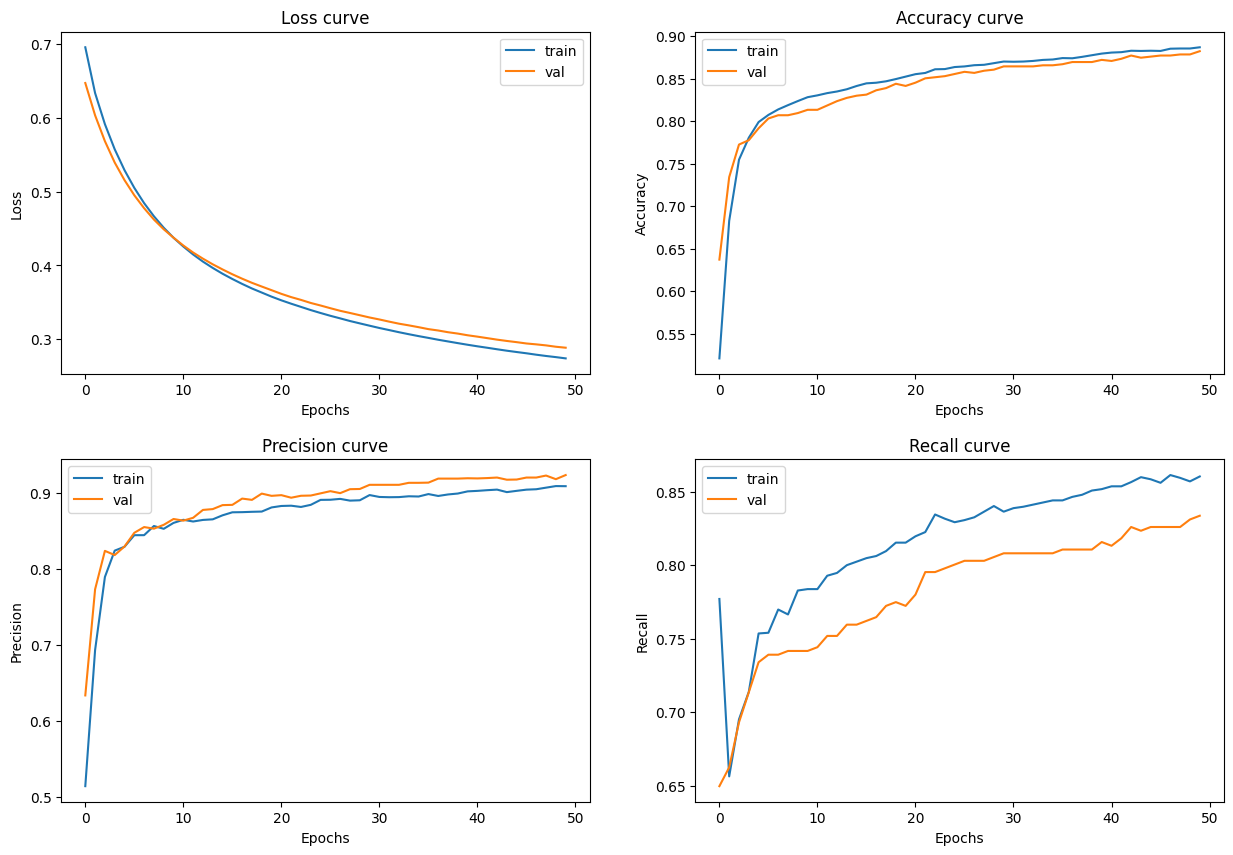

In [14]:
plot_metrics_curve(train_hist)

# Evaluation

In [23]:
y_true, y_pred, y_score = eval(model, dataloaders['test'], criterion, device=DEVICE, verbose=False, evaluate=True, print_report=True)

           class | support   | precision | recall    | f1-score  | avg-precision | roc-auc-score | log-loss  |
---------------------------------------------------------------------------------------------------------------
               0 | 130       | 0.90      | 0.92      | 0.91      | -             | -             | -         |
               1 | 131       | 0.91      | 0.90      | 0.91      | -             | -             | -         |
---------------------------------------------------------------------------------------------------------------
accuracy (micro) | 261       | 0.91      | 0.91      | 0.91      | 0.87          | 0.91          | 3.31      |
       macro avg | 261       | 0.91      | 0.91      | 0.91      | 0.87          | 0.91          | 3.31      |
    weighted avg | 261       | 0.91      | 0.91      | 0.91      | 0.87          | 0.91          | 3.31      |



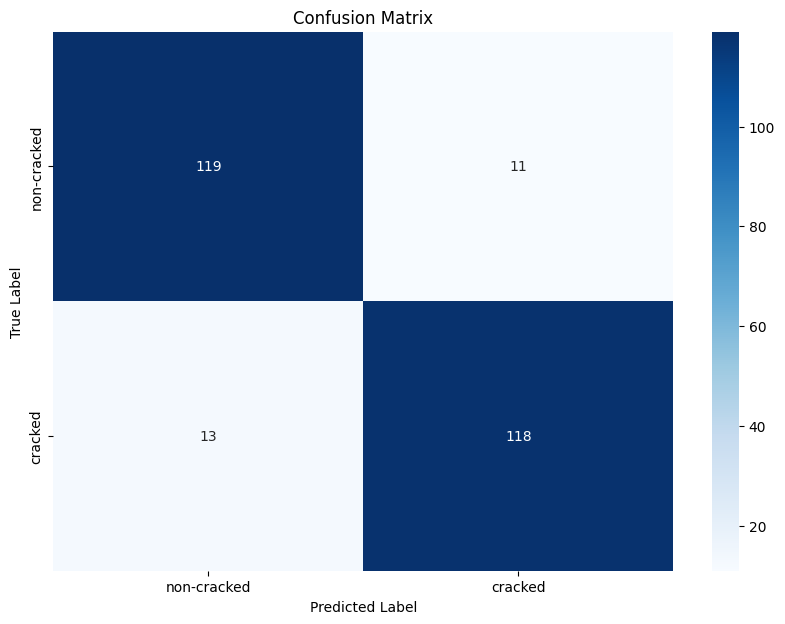

In [24]:
plot_conf_matrix(y_true, y_pred, classes=['non-cracked', 'cracked'])

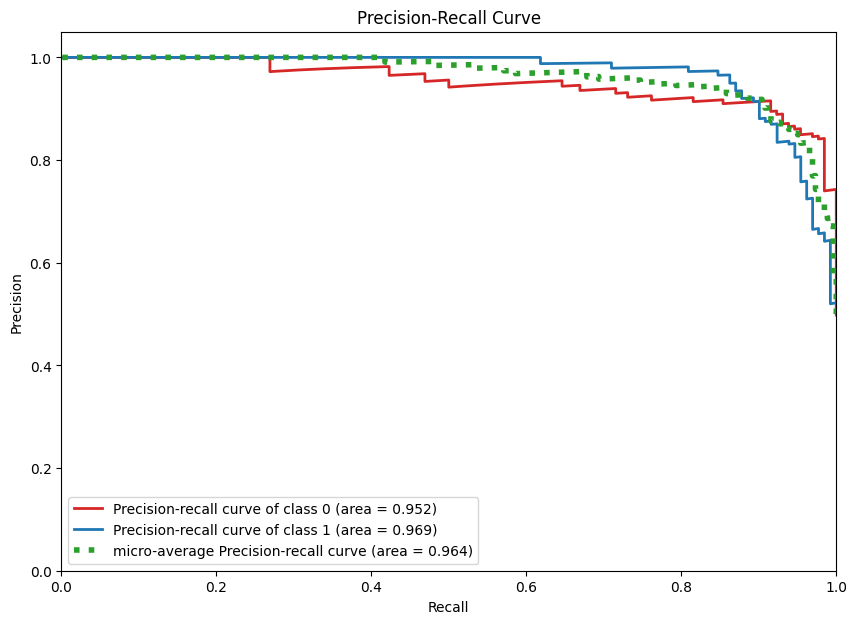

In [25]:
plot_precision_recall_curve(y_true, y_score)

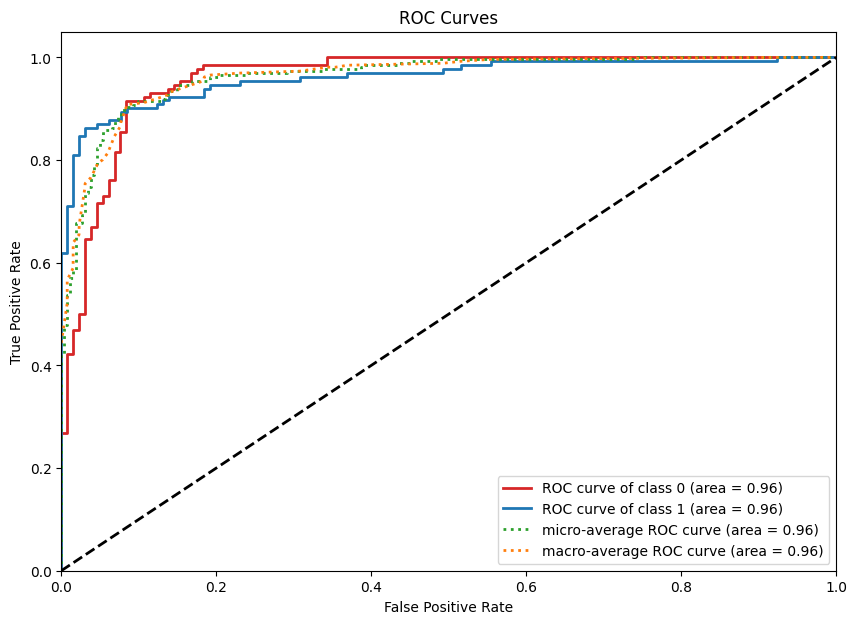

In [26]:
plot_roc_curve(y_true, y_score)

# Hyperparameter Optimization

In [79]:
# Training mode
PRETRAINED = True

In [80]:
def get_dataloaders(BATCH_SIZE, PRETRAINED):
    # define the input image dimensions
    IMG_SIZE = 224
    
    if PRETRAINED:
        MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
    else:
        MEAN, STD = calculate_mean_std(train_df.copy())

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD), 
        ]),
        'valid': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
        ])
    }

    dataloaders = {
        'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                            batch_size=BATCH_SIZE, shuffle=True, 
                            pin_memory=PIN_MEMORY),
        'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                            batch_size=BATCH_SIZE, shuffle=False, 
                            pin_memory=PIN_MEMORY),
        'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                           batch_size=1, shuffle=False,
                           pin_memory=PIN_MEMORY)
    }

    return dataloaders

In [81]:
# Define hyperparameter ranges
batch_size_list = [16, 32, 64]
epochs_list = [25, 50, 100]
learning_rate_list = [1.5e-4, 2.5e-5, 1.5e-5]

In [82]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

best_score = 0
best_params = None

num_classes = len(df.label.unique())

for batch_size in batch_size_list:
    for epochs in epochs_list:
        for learning_rate in learning_rate_list:
            dataloaders = get_dataloaders(batch_size, PRETRAINED)

            model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=PRETRAINED, trainable_layers=6)
            model = model.to(DEVICE)

            criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

            params_to_tune = [param for param in model.parameters() if param.requires_grad]
            optimizer = optim.SGD(params_to_tune, lr=learning_rate, momentum=0.9)

            scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-6)

            model_name = model.model_name
            dataset_name = dataloaders['train'].dataset.dataset_name

            save_dir = f"search_2/{model_name}_on_{dataset_name}_bsize_{batch_size}_epoch_{epochs}_lr_{learning_rate}"
            train(model, epochs, dataloaders, DEVICE, criterion, optimizer, scheduler=None, multiple_gpu=True, save_dir=save_dir, save=False, verbose=False)

            val_loss, val_acc = eval(model, dataloaders['valid'], criterion, DEVICE)
            if val_loss < best_score:
                best_score = val_loss
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': learning_rate}

print("Best score:", best_score)
print("Best parameters:", best_params)


Best score: 0.5982830458804106
Best parameters: {'batch_size': 16, 'epochs': 100, 'lr': 0.00025}
